In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

#url_B = "https://raw.githubusercontent.com/Yannngn/COVID19-04-20/master/brasil.csv"
#url_C = "https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/42831846b6d7e37dd600253a81098f8a_Download_COVID19_20200502.csv"

In [2]:
url_B = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
url_G = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"

filename = url_B.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url_B)
    r.encoding = "UTF-8"
    f.write(r.content)

In [3]:
color = ['#e8615d', '#f49436', '#2d9de5', '#3bbdbd', '#634792']
color2 = ['#00876c', '#379469', '#58a066', '#78ab63', '#98b561', '#b8bf62', '#dac767',
          '#deb256', '#e09d4b', '#e18745', '#e06f45', '#dc574a', '#d43d51']
color3 = ['#00876c', '#4ea06d', '#84b76e', '#bbcd73', '#f4e07f', '#f4ba61', '#ef9250', 
          '#e5694c', '#d43d51']

In [4]:
Norte = ["AC", "AM", "AP", "PA", "RO", "RR", "TO"]
Nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
Sudeste = ['ES', 'MG', 'RJ', 'SP']
Sul = ['PR', 'RS', 'SC']
Centro_oeste = ['DF', 'GO', 'MT', 'MS']

Regiao = [Nordeste, Norte, Sudeste, Sul, Centro_oeste]
reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

IFR_BR = [[['AL', 1.1], ['BA', 1.1], ['CE', 1.1], ['MA', 1], ['PB', 1.2], ['PE', 1.1], ['PI', 0], ['RN', 1.1], ['SE', 0]],
          [["AC", 0], ["AM", 0.8], ["AP", 0], ["PA", 0.9], ["RO", 0], ["RR", 0], ["TO", 0]],
          [['ES', 0.9], ['MG', 1], ['RJ', 0.8], ['SP', 0.7]],
          [['PR', 0], ['RS', 0.9], ['SC', 0.8]],
          [['DF', 0], ['GO', 0], ['MT', 0], ['MS', 0]]
         ]

In [5]:
df = pd.read_csv(filename, sep = ",")

df1 = df.drop(['epidemiological_week', 'is_repeated'], axis = 1).sort_values('date', ascending = True)
df1.rename(columns={'last_available_confirmed' : 'confirmed', 'last_available_confirmed_per_100k_inhabitants' : 'incidence',
                    'estimated_population_2019' : 'population','last_available_deaths' : 'deaths',
                    'last_available_death_rate' : 'death_rate', 'order_for_place' : 'day', 'last_available_date' : 'day_count'}, inplace = True)

In [6]:
for r in range(len(Regiao)) :
    for a in range(len(Regiao[r])) :
        df1.loc[df1['state'].eq(Regiao[r][a]), 'region'] = reg[r]
        df1.loc[df1['state'].eq(IFR_BR[r][a][0]), 'IFR'] = IFR_BR[r][a][1]

In [7]:
FMT = '%Y-%m-%d'

date = df1['date']
regi = df1['region']

df1['day_count'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-25", FMT)).days)

In [8]:
df_Brasil = df1.loc[df1['city'].isnull(), :].drop(['place_type', 'city_ibge_code', 'population', 'day', 
                                                  'incidence', 'death_rate', 'IFR', 'is_last', 'date'
                                                 ], axis = 1).groupby('day_count').sum()

df_pop = df1.loc[df1['city'].isnull() & (df1['is_last']), ['population', 'state']].reset_index(drop = True)

In [9]:
pBrasil = df_pop['population'].sum()

# total of days since 2020-01-30 - x
days = list(df_Brasil.index)
x = days

In [10]:
def exponential_model (x, a, b, c) :
    return a * np.exp (b * (x - c))

#curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

def exp_param (R, X) :
    a = np.exp(X[2] * (((np.log(R[2])) / X[2]) - ((np.log(R[1]) - np.log(R[0])) / (X[1] - X[0]))))
    b = (np.log(R[2])/X[2]) - (1/X[2])*(((np.log(R[0])/X[0]) - (np.log(R[1]) / X[1])) / ((X[0])**(-1) - (X[1]) ** (-1)))
    return [a, b]

def exp_est (R, X) :
    np.random.seed(max(x))
    a = np.exp(X[2] * (((np.log(R[2])) / X[2]) - ((np.log(R[1]) - np.log(R[0])) / (X[1] - X[0]))))
    b = (np.log(R[2]) / X[2]) - (1 / X[2]) * (((np.log(R[0]) / X[0]) - (np.log(R[1]) / X[1])) / ((X[0]) ** (-1) - (X[1]) ** (-1)))
    return a * np.exp(b * (max(x) + 1)) + norm.rvs(size = 1, scale = 0.05 * (max(x) + 1))

In [11]:
desc = ["Total Cases Number", "Total Deaths Number", "New Cases", "New Deaths"]

for i in range(4) :
    y = list(df_Brasil.iloc[:, i])
    d0 = int(5 * max(days) / 9)
    d1 = int(7 * max(days) / 9)
    
    exp_p = exp_param([y[d0], y[d1], y[-1]], [x[d0], x[d1], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0], exp_p[1], 1])
    
    exponential_errors = [np.sqrt(exponential_fit[1][j][j]) for j in range(3)]
    print(desc[i] + " parameters are: \n")
    for j in range(3) :
        print(str(round(exponential_fit[0][j], 3)) + " +/- " + str(round(exponential_errors[j], 3)))
    print(" \n")

Total Cases Number parameters are: 

5034.944 +/- 1980848377.772
0.035 +/- 0.001
-34.904 +/- 11276089.249
 

Total Deaths Number parameters are: 

1013.971 +/- 250968902.023
0.029 +/- 0.001
-16.22 +/- 8645290.141
 

New Cases parameters are: 

424.258 +/- 560318218.937
0.024 +/- 0.001
-59.502 +/- 54795224.889
 

New Deaths parameters are: 

33.872 +/- 95784518.719
0.017 +/- 0.001
-83.872 +/- 166574869.826
 



## logistic model

a refers to the infection speed
b is the day with the maximum infections occurred
c is the total number of recorded infected people at the infection’s end

velocidade da infecção: 2

dia de máximo de infecções: daqui a 2 semanas
dia de máximo de mortes: daqui a 4 semanas

população do Brasil: 209.500.000
população máxima infectada: 60%
população máxima infectada num dia: 2%
população máxima morta: 0.6%
população máxima morta num dia: 0.02%

In [12]:
# logistic model of the evolution of the contamination in Brazil

def logistic_model (x, a, b, c) :
    return c / (1 + np.exp ( - (x - b) / a))

# curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

In [13]:
print("The errors of the logistic model parameters of: \n")

a0 = 1.2

lb = [max(days) + 14, max(days) + 14, max(days) + 14, max(days) + 31]


lc = [0.5 * pBrasil, 0.025 * pBrasil, 0.05 * pBrasil, 0.08 * pBrasil]

for i in range(4) :
    x = days
    y = list(df_Brasil.iloc[:, i])

    logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, lb[i], lc[i]])
    logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1],
                                                        logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))
    
    logistic_errors = [np.sqrt(logistic_fit[1][j][j]) for j in [0, 1, 2]]
   
    print(desc[i] + " numbers are: " + str(logistic_errors) + "\n")

The errors of the logistic model parameters of: 

Total Cases Number numbers are: [0.20309780912767608, 0.6205931829910686, 40966.62198519917]

Total Deaths Number numbers are: [0.25081589320797254, 0.5181760514728265, 937.7133354944917]

New Cases numbers are: [1.891003986704648, 3.0648721861299113, 2657.268112315343]

New Deaths numbers are: [1.3193837995281559, 1.5610549059218186, 30.506838308387945]




# Gráficos
## Cores

    branco --> #c2cdd8
    cinza --> #a1a9b4
    azul --> #3881b8
    azul --> #235174
    preto --> #1d2b49

The expected final values: end of spread in 314 +/- 0.62 days, with 2551140.02 +/- 40966.62 Confirmed COVID19 cases

E:\Users\Charles\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



Next estimated Confirmed COVID19 cases number is 2098479.562


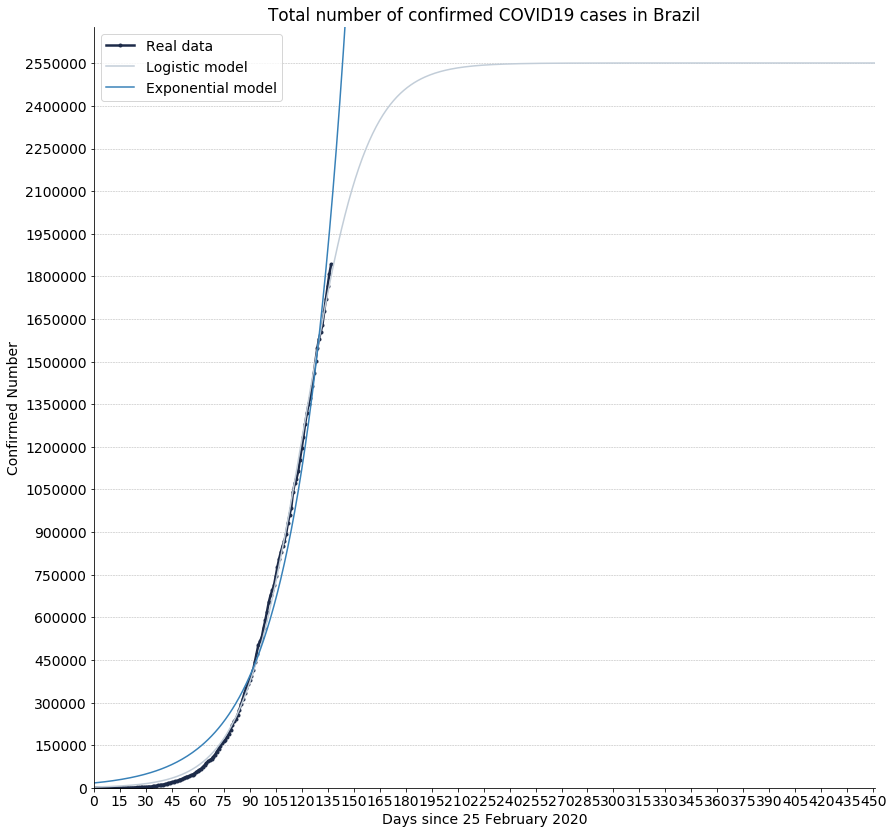

E:\Users\Charles\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The expected final values: end of spread in 169 +/- 0.52 days, with 79621.603 +/- 937.71 Deaths by COVID19
Next estimated Deaths by COVID19 number is 84124.664


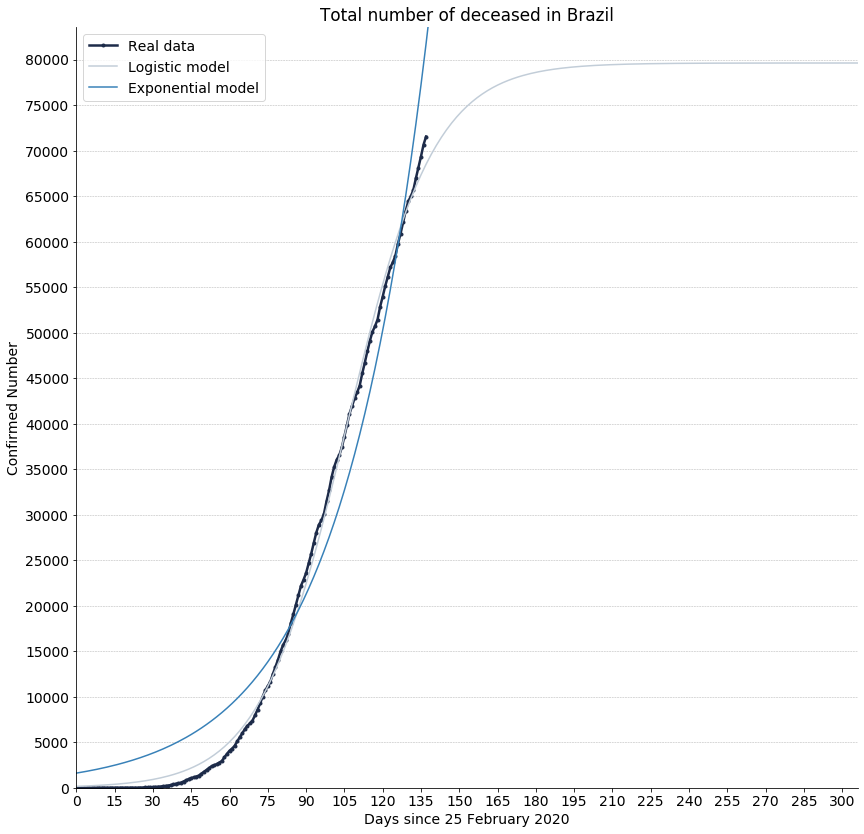

E:\Users\Charles\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
E:\Users\Charles\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt


The expected final values: end of spread in 131 +/- 3.06 days, with 41704.872 +/- 2657.27 New confirmed COVID19 cases
Next estimated New confirmed COVID19 cases number is 49544.905


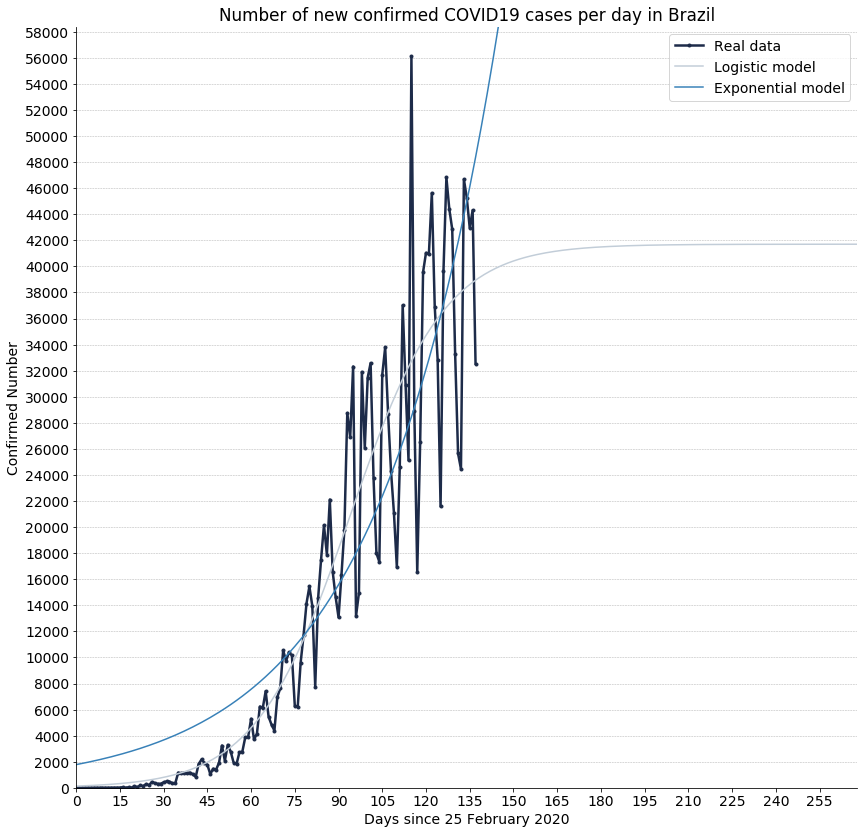

E:\Users\Charles\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
E:\Users\Charles\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The expected final values: end of spread in 7 +/- 1.56 days, with 1042.524 +/- 30.51 New confirmed deaths
Next estimated New confirmed deaths number is 1421.792


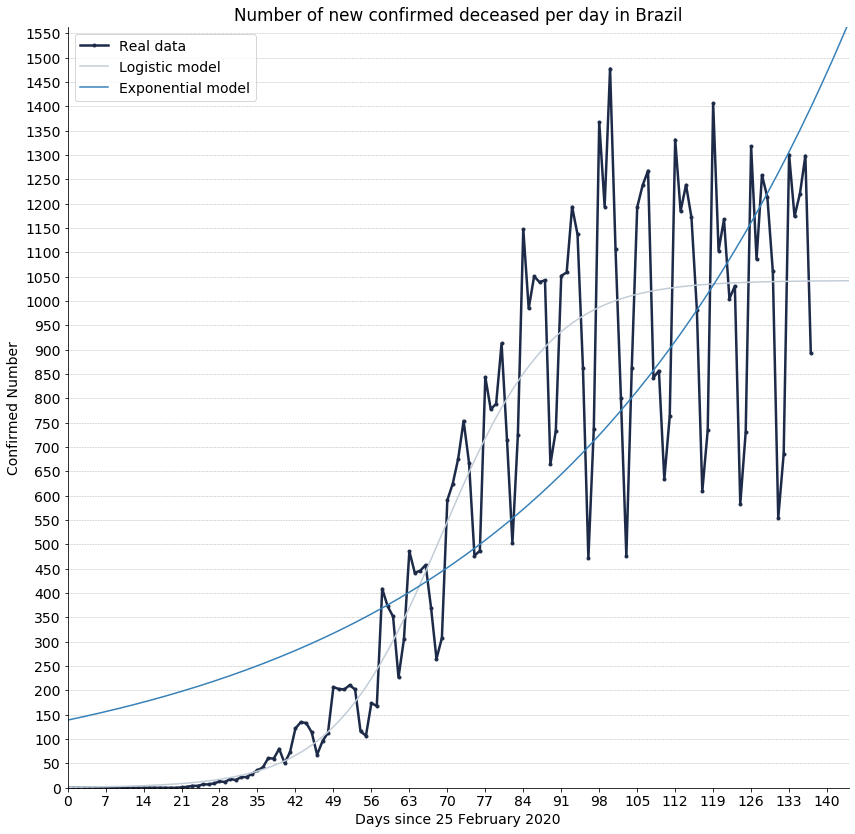

In [14]:
ttl = ["Total number of confirmed COVID19 cases",
        "Total number of deceased",
        "Number of new confirmed COVID19 cases per day",
        "Number of new confirmed deceased per day"]
desc = ["Confirmed COVID19 cases",
        "Deaths by COVID19",
        "New confirmed COVID19 cases",
        "New confirmed deaths"]
expo = []

for f in range(4) :
    plt.rc('font', size = 14)
    plt.rcParams['figure.figsize'] = [14, 14]
    
    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
    
    x = days
    
    y = list(df_Brasil.iloc[:, f])
      
    exp_p = exp_param([y[d0], y[d1], y[-1]], [x[d0], x[d1], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0] * np.exp(-1), exp_p[1], 1])
    exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                              exponential_fit[0][2]) - int(exponential_fit[0][2]),
                                 exponential_fit[0][1]))
    exponential_errors = [np.sqrt(exponential_fit[1][j][j]) for j in [0, 1, 2]]
    
    pred_x = list(range(max(x), max(x) + 15 ))

    # Real data
    plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49", lw = 2.5)
    # Predicted logistic curve for the total data
    logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, lb[f], lc[f]])
    logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], 
                                                        logistic_fit[0][1], logistic_fit[0][2])
                              - int(logistic_fit[0][2]), logistic_fit[0][1]))

    logistic_errors = [np.sqrt(logistic_fit[1][j][j]) for j in [0, 1, 2]]

    pred_x = list(range(max(x), logistic_sol))

    plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2]) 
                          for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")
    
    print("The expected final values: end of spread in " + str(max(pred_x) - max(x))
          + " +/- " + str(round(logistic_errors[1], 2)) + " days, with " + str(round(logistic_fit[0][2], 3))
          + " +/- " + str(round(logistic_errors[2], 2)) + " " + desc[f])
        
    # Predicted exponential curve
    plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                          for i in x + pred_x], label = "Exponential model", color = "#3881b8")
    
    expo.append(exponential_fit)

    plt.title(ttl[f] + " in Brazil")
    plt.legend()
    plt.xlabel("Days since 25 February 2020")
    plt.ylabel("Confirmed Number")
    
    ymult = [1.05, 1.05, 1.4, 1.5]
    plt.xlim(0, max(pred_x))
    plt.ylim(0, logistic_fit[0][2] * ymult[f])
    
    xtick = [15, 15, 15, 7]
    
    ytick = [.5 * round(logistic_fit[0][2] * 10 ** (-6)) * 10 ** 5,
             .5 * round(logistic_fit[0][2] * 10 ** (-5)) * 10 ** 4,
             .5 * round(logistic_fit[0][2] * 10 ** (-4)) * 10 ** 3,
             .5 * round(logistic_fit[0][2] * 10 ** (-3)) * 10 ** 2]
    
    plt.xticks(np.arange(0, max(pred_x), xtick[f]))
    plt.yticks(np.arange(0, logistic_fit[0][2] * ymult[f], ytick[f]))
    
    print("Next estimated " + desc[f] + " number is " + 
          str(round(exponential_model(max(x) + 1, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]), 3)))
    plt.show()

In [15]:
df_Brasil

,confirmed,deaths,new_confirmed,new_deaths
day_count,,,,
0,1,0,1,0
1,1,0,0,0
2,1,0,0,0
3,2,0,1,0
4,2,0,0,0
...,...,...,...,...
133,1676841,66952,46694,1301
134,1722093,68126,45252,1174
135,1765055,69347,42962,1221


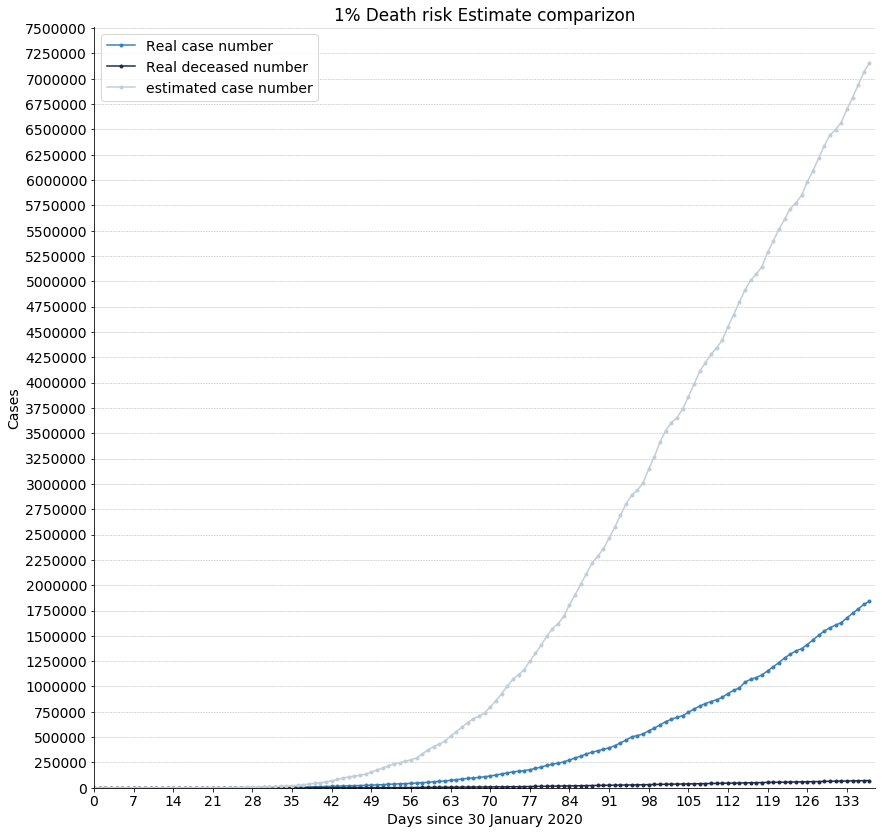

Expected actual value is: 7154000 in day 137


In [16]:
plt.rc('font', size = 14)
plt.rcParams['figure.figsize'] = [14, 14]

plt.gca().spines["top"].set_visible(False)    
plt.gca().spines["right"].set_visible(False)
plt.gca().get_xaxis().tick_bottom()    
plt.gca().get_yaxis().tick_left()
plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)

# Real data

y = list(df_Brasil.iloc[:, 0])
plt.plot(x, y, marker = '.', label = "Real case number", color = "#3881b8")

y = list(df_Brasil.iloc[:, 1])

plt.plot(x, y, marker = '.', label = "Real deceased number", color = "#1d2b49")

y = list(df_Brasil.iloc[:, 1].multiply(100))

plt.plot(x, y, marker = '.', label = "estimated case number", color = "#c2cdd8")

plt.title("1% Death risk Estimate comparizon")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")

plt.xlim(30, max(x) + 1)
plt.ylim(0, max(y) * 1.05)

plt.xticks(np.arange(0, max(x) + 1, 7))
plt.yticks(np.arange(0, max(y) * 1.05, 250000))

plt.show()
print("Expected actual value is: " + str(max(y)) + " in day " + str(max(x)))

ValueError: could not convert string to float: 'São Paulo'

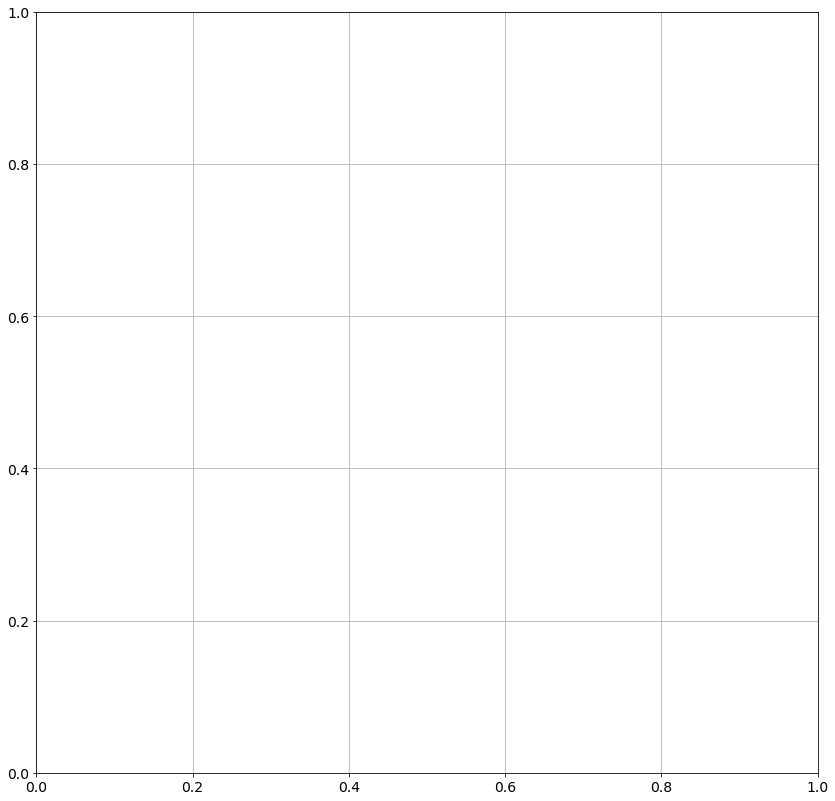

In [17]:
inicio = [33, 47]
ttl = ["Confirmed Cases", "Confirmed Deaths"]
for f in range(2) :
    plt.grid(True)
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 7]

    # Lines
    x = days
    y = list(df1.iloc[:, 2 * f])

    logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, lb[f], lc[f]])
    logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1],
                                                        logistic_fit[0][2]) - int(logistic_fit[0][2]),
                              logistic_fit[0][1]))

    exp_p = exp_param([y[-4], y[-2], y[-1]], [x[-4], x[-2], x[-1]])
    exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0] - 1, exp_p[1], 1])

    pred_x = list(range(max(x), logistic_sol))

    plt.plot(x + pred_x, [exponential_model(i + inicio[f], exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                              for i in x + pred_x], label = "Exponential model", color = "#3881b8")

    # Real data

    x = list(df1.head(max(days) - inicio[f]).index)

    y = list(df1.iloc[:, 2 * f].tail(max(days) - inicio[f]))
    plt.plot(x, y, marker = '.', label = "Real numbers", color = "#1d2b49")

    plt.title(ttl[f] + " logaritmic scale growth comparizon")
    plt.legend()
    plt.yscale('log')
    plt.xlabel("Days since first " + ttl[f])
    plt.ylabel(ttl[f])
    plt.xlim(0, max(x) * 1.01)
    plt.ylim(3, max(y) * 1.5)
    plt.show()

    print("The growth rate of " + ttl[f] + " is: doubling every " + str(int(round(np.log(2) / exponential_fit[0][1], 0))) + " days")